In [8]:
import pandas as pd
import numpy as np
import os, sys
import datetime
import azure.functions as func
from azure.storage.blob import BlobClient
import requests
import matplotlib.pyplot as plt
import json
import pytz
import iso8601
import seaborn as sns
from dotenv import load_dotenv


load_dotenv()

AZURE_BLOB_STORAGE_SECRET = os.getenv("AZURE_BLOB_STORAGE_SECRET")
AZURE_URL = os.getenv("AZURE_URL")

# Ta ut information från en dag

In [65]:
chosen_day = "2023-05-04"

blob_name = str(chosen_day)+".json"
blob_client = BlobClient(account_url=AZURE_URL,
                            container_name="importedfiles",
                            blob_name=blob_name,
                            credential=AZURE_BLOB_STORAGE_SECRET)

data = blob_client.download_blob().readall().decode("utf-8")

df = pd.read_json(data)

df.sort_values(by="startTs", ascending=True)
df.tail()


,startTs,endTs,clientCount
67,2023-05-03T22:20:00Z,2023-05-03T22:40:00Z,27
68,2023-05-03T22:40:00Z,2023-05-03T23:00:00Z,27
69,2023-05-03T23:00:00Z,2023-05-03T23:20:00Z,26
70,2023-05-03T23:20:00Z,2023-05-03T23:40:00Z,27
71,2023-05-03T23:40:00Z,2023-05-04T00:00:00Z,26


In [55]:
df.endTs.to_numpy()

array(['2023-05-03T00:20:00Z', '2023-05-03T00:40:00Z',
       '2023-05-03T01:00:00Z', '2023-05-03T01:20:00Z',
       '2023-05-03T01:40:00Z', '2023-05-03T02:00:00Z',
       '2023-05-03T02:20:00Z', '2023-05-03T02:40:00Z',
       '2023-05-03T03:00:00Z', '2023-05-03T03:20:00Z',
       '2023-05-03T03:40:00Z', '2023-05-03T04:00:00Z',
       '2023-05-03T04:20:00Z', '2023-05-03T04:40:00Z',
       '2023-05-03T05:00:00Z', '2023-05-03T05:20:00Z',
       '2023-05-03T05:40:00Z', '2023-05-03T06:00:00Z',
       '2023-05-03T06:20:00Z', '2023-05-03T06:40:00Z',
       '2023-05-03T07:00:00Z', '2023-05-03T07:20:00Z',
       '2023-05-03T07:40:00Z', '2023-05-03T08:00:00Z',
       '2023-05-03T08:20:00Z', '2023-05-03T08:40:00Z',
       '2023-05-03T09:00:00Z', '2023-05-03T09:20:00Z',
       '2023-05-03T09:40:00Z', '2023-05-03T10:00:00Z',
       '2023-05-03T10:20:00Z', '2023-05-03T10:40:00Z',
       '2023-05-03T11:00:00Z', '2023-05-03T11:20:00Z',
       '2023-05-03T11:40:00Z', '2023-05-03T12:00:00Z',
       '20

<Axes: title={'center': 'Kontorsaktivitet 2023-05-04'}, xlabel='Tid', ylabel='Antal'>

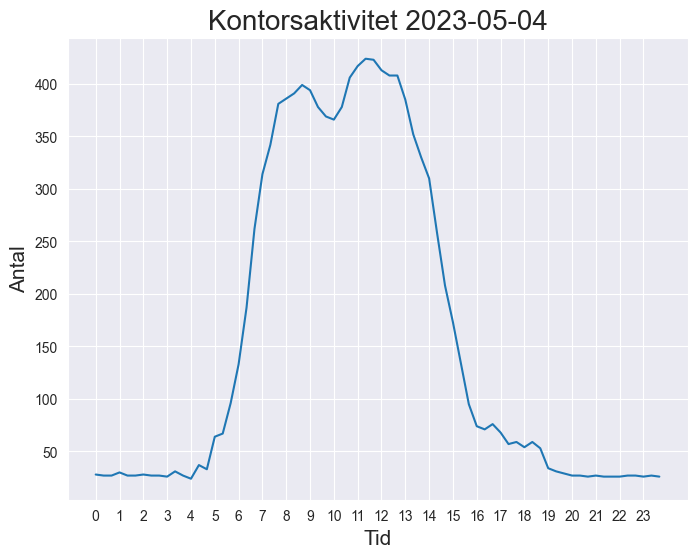

In [56]:
# Plot

sns.set_style("darkgrid")

fig, ax = plt.subplots(figsize=(8,6))

ax.set_xticks(range(0,72,3),  range(0,24,1))
ax.set_ylabel("Antal", fontsize=15)
ax.set_xlabel("Tid", fontsize=15)

ax.set_title("Kontorsaktivitet " + chosen_day, fontsize=20)

sns.lineplot(data=df, x="startTs", y="clientCount", ax=ax)

# Ta ut information från flera dagar

In [67]:
day_list = ["2023-05-03", "2023-05-04"]

df_list = []

for date in day_list:
    blob_name = str(date)+".json"
    blob_client = BlobClient(account_url=AZURE_URL,
                             container_name="importedfiles",
                             blob_name=blob_name,
                             credential=AZURE_BLOB_STORAGE_SECRET)
    data = blob_client.download_blob().readall().decode("utf-8")

    df = pd.read_json(data)
    df_list.append(df)

df = pd.concat(df_list).reset_index(drop=True)
#print(f"Shape of df: {df.shape}")
df.sort_values(by="startTs", ascending=True)
df.tail()

,startTs,endTs,clientCount
139,2023-05-03T22:20:00Z,2023-05-03T22:40:00Z,27
140,2023-05-03T22:40:00Z,2023-05-03T23:00:00Z,27
141,2023-05-03T23:00:00Z,2023-05-03T23:20:00Z,26
142,2023-05-03T23:20:00Z,2023-05-03T23:40:00Z,27
143,2023-05-03T23:40:00Z,2023-05-04T00:00:00Z,26


# Fixa datetime

In [68]:
df.rename(columns={"startTs":"dateTimeZ"}, inplace=True)
df.drop(columns=["endTs"], inplace=True)

tz = pytz.timezone("Europe/Stockholm")
df.dateTimeZ = pd.to_datetime(df.dateTimeZ)
df["dateTime"] = df.dateTimeZ.dt.tz_convert(tz)
df["date"] = df.dateTime.dt.date
df["time"] = df.dateTime.dt.time
df.dateTime = pd.to_datetime(df.dateTime.dt.strftime("%Y-%m-%dT%H:%M:%S"))
df.drop("dateTimeZ", axis=1, inplace=True)

print(f"Shape of df: {df.shape}")
df.tail()

Shape of df: (144, 4)


,clientCount,dateTime,date,time
139,27,2023-05-04 00:20:00,2023-05-04,00:20:00
140,27,2023-05-04 00:40:00,2023-05-04,00:40:00
141,26,2023-05-04 01:00:00,2023-05-04,01:00:00
142,27,2023-05-04 01:20:00,2023-05-04,01:20:00
143,26,2023-05-04 01:40:00,2023-05-04,01:40:00


In [69]:
df = df.loc[df.date == datetime.date(2023, 5, 3)].reset_index(drop=True)
df

,clientCount,dateTime,date,time
0,29,2023-05-03 00:00:00,2023-05-03,00:00:00
1,29,2023-05-03 00:20:00,2023-05-03,00:20:00
2,29,2023-05-03 00:40:00,2023-05-03,00:40:00
3,29,2023-05-03 01:00:00,2023-05-03,01:00:00
4,30,2023-05-03 01:20:00,2023-05-03,01:20:00
...,...,...,...,...
67,27,2023-05-03 22:20:00,2023-05-03,22:20:00
68,26,2023-05-03 22:40:00,2023-05-03,22:40:00
69,27,2023-05-03 23:00:00,2023-05-03,23:00:00
70,26,2023-05-03 23:20:00,2023-05-03,23:20:00


In [85]:
df.columns

Index(['clientCount', 'dateTime', 'date', 'time'], dtype='object')

<Axes: title={'center': 'Kontorsaktivitet 2023-05-04'}, xlabel='Tid', ylabel='Antal'>

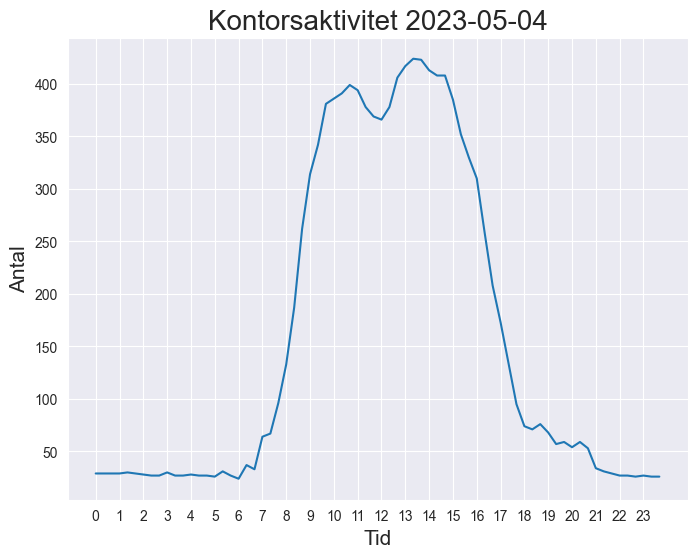

In [89]:
# Plot

sns.set_style("darkgrid")

fig2, ax2 = plt.subplots(figsize=(8,6))

ax2.set_xticks(range(0,72,3),  range(0,24,1))
ax2.set_ylabel("Antal", fontsize=15)
ax2.set_xlabel("Tid", fontsize=15)

ax2.set_title("Kontorsaktivitet " + chosen_day, fontsize=20)

sns.lineplot(data=df, x=range(0,72,1), y="clientCount", ax=ax2)